In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Dataset

In [4]:
batch_size = 64

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

## Visualize

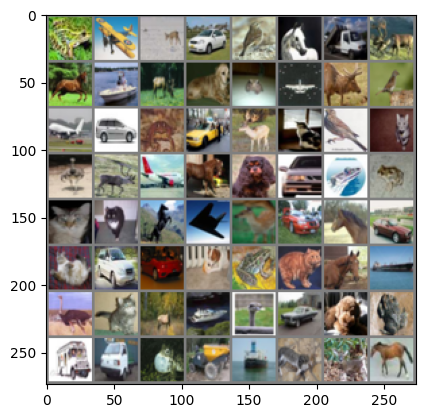

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [9]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Build Model

## CNN

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## RNN

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size=96, hidden_size=128, num_layers=1, num_classes=10):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, height, width, channels)
        batch_size = x.size(0)

        # Reshape to (batch_size, sequence_length, input_size)
        # Treat each row as a sequence, with pixels in that row as features
        x = x.permute(0, 2, 1, 3)  # (batch_size, width, height, channels)
        x = x.reshape(batch_size, 32, -1)  # (batch_size, width, height * channels)

        # Pass through RNN
        # out shape: (batch_size, seq_len, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        _, h_n = self.rnn(x)

        # Use the last hidden state from the last layer
        out = self.fc1(h_n[-1])
        out = self.fc2(out)

        return out

## LSTM

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=96, hidden_size=128, num_layers=1, num_classes=10):
        super(LSTM, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        # Fully connected layer
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, height, width, channels)
        batch_size = x.size(0)

        # Reshape to (batch_size, sequence_length, input_size)
        # Treat each row as a sequence, with pixels in that row as features
        x = x.permute(0, 2, 1, 3)  # (batch_size, width, height, channels)
        x = x.reshape(batch_size, 32, -1)  # (batch_size, width, height * channels)

        # Pass through LSTM
        # out shape: (batch_size, seq_len, hidden_size)
        # h_n shape: (num_layers, batch_size, hidden_size)
        _, (h_n, _) = self.lstm(x)

        # Use the last hidden state from the last layer
        out = self.fc1(h_n[-1])
        out = self.fc2(out)
        return out

## Transformer (ViT)

In [13]:
!pip install vit_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 10.6 MB/s eta 0:00:00


In [14]:
from vit_pytorch import ViT
vit_model = ViT(
    image_size=32,
    patch_size=4,
    channels=3,
    num_classes=10,
    dim=128,
    depth=1,
    heads=8,
    mlp_dim=512
)

# Set up hyperparameter

In [15]:
models = {
    'CNN': CNN().to(device),
    'RNN': RNN().to(device),
    'LSTM': LSTM().to(device),
    'Transformer': vit_model.to(device)
}

In [16]:
epochs = 10
learning_rate = 0.001
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training

In [17]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [18]:
def train_model(model, criterion, optimizer):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0   # to track number of correct predictions
        total = 0             # to track total number of samples

        for i, (inputs, labels) in enumerate(trainloader, 0):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Determine class predictions and track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()


        epoch_accuracy = 100 * running_correct / total
        epoch_loss = running_loss / (i + 1)

        test_loss, test_accuracy = evaluate(model, testloader, criterion)
        print(f"Epoch [{(epoch + 1):3}/{epochs:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")

        # save for plot
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

In [19]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'CNN':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training CNN
Epoch [  1/ 10] 	 Loss: 1.27539     Accuracy: 54.19% 	 Test Loss: 0.94374     Test Accuracy: 67.29%
Epoch [  2/ 10] 	 Loss: 0.80140     Accuracy: 71.92% 	 Test Loss: 0.82052     Test Accuracy: 71.19%
Epoch [  3/ 10] 	 Loss: 0.51770     Accuracy: 81.94% 	 Test Loss: 0.83617     Test Accuracy: 73.21%
Epoch [  4/ 10] 	 Loss: 0.23918     Accuracy: 91.80% 	 Test Loss: 1.15574     Test Accuracy: 70.33%
Epoch [  5/ 10] 	 Loss: 0.09951     Accuracy: 96.66% 	 Test Loss: 1.29458     Test Accuracy: 71.12%
Epoch [  6/ 10] 	 Loss: 0.06942     Accuracy: 97.65% 	 Test Loss: 1.64129     Test Accuracy: 70.24%
Epoch [  7/ 10] 	 Loss: 0.05973     Accuracy: 98.04% 	 Test Loss: 1.72000     Test Accuracy: 71.08%
Epoch [  8/ 10] 	 Loss: 0.05282     Accuracy: 98.17% 	 Test Loss: 1.89045     Test Accuracy: 69.75%
Epoch [  9/ 10] 	 Loss: 0.05101     Accuracy: 98.30% 	 Test Loss: 1.78616     Test Accuracy: 71.20%
Epoch [ 10/ 10] 	 Loss: 0.04055     Accuracy: 98.67% 	 Test Loss: 2.03214     Test Accu

In [20]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'RNN':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training RNN
Epoch [  1/ 10] 	 Loss: 2.04139     Accuracy: 25.14% 	 Test Loss: 1.96336     Test Accuracy: 27.02%
Epoch [  2/ 10] 	 Loss: 1.92866     Accuracy: 28.85% 	 Test Loss: 1.86799     Test Accuracy: 32.12%
Epoch [  3/ 10] 	 Loss: 1.85079     Accuracy: 32.07% 	 Test Loss: 1.82812     Test Accuracy: 33.05%
Epoch [  4/ 10] 	 Loss: 1.87662     Accuracy: 31.54% 	 Test Loss: 1.92409     Test Accuracy: 30.20%
Epoch [  5/ 10] 	 Loss: 1.87382     Accuracy: 31.40% 	 Test Loss: 1.80409     Test Accuracy: 33.64%
Epoch [  6/ 10] 	 Loss: 1.79072     Accuracy: 34.23% 	 Test Loss: 1.78104     Test Accuracy: 35.36%
Epoch [  7/ 10] 	 Loss: 1.75718     Accuracy: 35.84% 	 Test Loss: 1.77815     Test Accuracy: 35.37%
Epoch [  8/ 10] 	 Loss: 1.74906     Accuracy: 35.73% 	 Test Loss: 1.80289     Test Accuracy: 34.35%
Epoch [  9/ 10] 	 Loss: 1.73573     Accuracy: 36.12% 	 Test Loss: 1.73518     Test Accuracy: 35.33%
Epoch [ 10/ 10] 	 Loss: 1.72234     Accuracy: 36.73% 	 Test Loss: 1.73363     Test Accu

In [ ]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'LSTM':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training LSTM
Epoch [  1/ 10] 	 Loss: 1.74423     Accuracy: 35.35% 	 Test Loss: 1.59766     Test Accuracy: 41.63%
Epoch [  2/ 10] 	 Loss: 1.48942     Accuracy: 45.58% 	 Test Loss: 1.42863     Test Accuracy: 47.41%
Epoch [  3/ 10] 	 Loss: 1.36344     Accuracy: 50.46% 	 Test Loss: 1.34378     Test Accuracy: 51.05%
Epoch [  4/ 10] 	 Loss: 1.26771     Accuracy: 54.11% 	 Test Loss: 1.31851     Test Accuracy: 52.59%
Epoch [  5/ 10] 	 Loss: 1.19525     Accuracy: 56.91% 	 Test Loss: 1.30159     Test Accuracy: 52.82%
Epoch [  6/ 10] 	 Loss: 1.12884     Accuracy: 59.47% 	 Test Loss: 1.26685     Test Accuracy: 54.97%
Epoch [  7/ 10] 	 Loss: 1.07734     Accuracy: 61.32% 	 Test Loss: 1.23684     Test Accuracy: 56.09%
Epoch [  8/ 10] 	 Loss: 1.02999     Accuracy: 63.06% 	 Test Loss: 1.25150     Test Accuracy: 55.56%
Epoch [  9/ 10] 	 Loss: 0.98257     Accuracy: 64.65% 	 Test Loss: 1.27631     Test Accuracy: 55.55%
Epoch [ 10/ 10] 	 Loss: 0.94555     Accuracy: 65.84% 	 Test Loss: 1.25050     Test Acc

In [ ]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'Transformer':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training Transformer
Epoch [  1/ 10] 	 Loss: 1.62300     Accuracy: 40.01% 	 Test Loss: 1.48138     Test Accuracy: 45.84%
Epoch [  2/ 10] 	 Loss: 1.39064     Accuracy: 49.35% 	 Test Loss: 1.36708     Test Accuracy: 50.09%
Epoch [  3/ 10] 	 Loss: 1.30801     Accuracy: 52.75% 	 Test Loss: 1.33114     Test Accuracy: 51.79%
Epoch [  4/ 10] 	 Loss: 1.26330     Accuracy: 54.23% 	 Test Loss: 1.29605     Test Accuracy: 53.33%
Epoch [  5/ 10] 	 Loss: 1.22162     Accuracy: 55.71% 	 Test Loss: 1.28259     Test Accuracy: 54.15%
Epoch [  6/ 10] 	 Loss: 1.19117     Accuracy: 56.98% 	 Test Loss: 1.23726     Test Accuracy: 55.58%
Epoch [  7/ 10] 	 Loss: 1.16267     Accuracy: 57.92% 	 Test Loss: 1.22249     Test Accuracy: 56.66%
Epoch [  8/ 10] 	 Loss: 1.13512     Accuracy: 59.04% 	 Test Loss: 1.25165     Test Accuracy: 54.87%
Epoch [  9/ 10] 	 Loss: 1.10725     Accuracy: 60.06% 	 Test Loss: 1.18032     Test Accuracy: 57.44%
Epoch [ 10/ 10] 	 Loss: 1.07820     Accuracy: 61.19% 	 Test Loss: 1.20830     T